# DGA Detection
## Experiment 2
<b><p id="intro" style="color: green">In this notebook we use the same dataset sample with 2000 rows and create and apply the function for N-gram feature extraction.
</p></b>
<a href="#WorkingOn">Go back</a>

In [21]:
# Load libraries 
import pandas as pd
import numpy as np
import regex as re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from pickle import dump
from pickle import load

<b><h3>Part 1 - Data Preprocessing</h3></b>

In [22]:
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/dga_data_small.csv')
df.head()

,isDGA,domain,host,subclass
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga
2,dga,thenrest,thenrest.net,nivdort
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga


In [23]:
# get shape of the data
df.shape

(2000, 4)

In [24]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

isDGA       0
domain      0
host        0
subclass    0
dtype: int64

In [25]:
# Eliminate duplicates if any and check the shape of the data
df = df.drop_duplicates()
df = df.reset_index(inplace=False, drop=True)
df.shape

(2000, 4)

In [26]:
print(f"DGA: {df['isDGA'].value_counts()['dga']}")
print(f"Legit: {df['isDGA'].value_counts()['legit']}")

DGA: 1000
Legit: 1000


<b><h3>Part 2 - Feature Engineering</h3></b>
<b><p style="color: green">
</p></b>

In [27]:
df.drop(['host', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.head()

(2000, 2)


,isDGA,domain
0,dga,tyopcrkqgxcfm
1,dga,72j5rn1l9mzleo6203v1ogenfl
2,dga,thenrest
3,dga,15ihbm71utcnfa8dk1mmgoobl9
4,dga,x1d6ou7e7kofk60ayhq74x7e


In [29]:
df['isDGA'] = df['isDGA'].apply(lambda x: 1 if x == 'dga' else 0)
df.head()

,isDGA,domain
0,1,tyopcrkqgxcfm
1,1,72j5rn1l9mzleo6203v1ogenfl
2,1,thenrest
3,1,15ihbm71utcnfa8dk1mmgoobl9
4,1,x1d6ou7e7kofk60ayhq74x7e


In [30]:
# Function to calculate Shannon Entropy
def H_entropy(domain):    
    prob = [ float(domain.count(c)) / len(domain) for c in dict.fromkeys(list(domain)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

# Function to get the index of the first digit of a given domain
def firstDigitIndex(domain):
    for i, c in enumerate(domain):
        if c.isdigit():
            return i + 1
    return 0

# Function to calculate number of digits 
def numDigits(domain):
    return sum(c.isdigit() for c in domain)

# Function to calculate vowel to consonant ratio
def vowel_consonant_ratio(domain):    
    domain = domain.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, domain)
    consonants = re.findall(consonants_pattern, domain)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

In [31]:
# Extract features from the domain (derive new features)
df['length'] = df['domain'].apply(lambda x: len(x))
df['digits'] = df['domain'].apply(lambda x: numDigits(x))
df['entropy'] = df['domain'].apply(lambda x: H_entropy(x))
df['vowel_cons'] = df['domain'].apply(lambda x: vowel_consonant_ratio(x))
df['firstDigitIndex'] = df['domain'].apply(lambda x: firstDigitIndex(x))
df.head()

,isDGA,domain,length,digits,entropy,vowel_cons,firstDigitIndex
0,1,tyopcrkqgxcfm,13,0,3.546594,0.083333,0
1,1,72j5rn1l9mzleo6203v1ogenfl,26,10,4.132944,0.333333,1
2,1,thenrest,8,0,2.500000,0.333333,0
3,1,15ihbm71utcnfa8dk1mmgoobl9,26,7,4.180833,0.357143,1
4,1,x1d6ou7e7kofk60ayhq74x7e,24,9,3.834963,0.666667,2


In [32]:
top_english_words = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/google-10000-english.txt', header=None, names=['words'])
top_english_words.head()
d = top_english_words
dump(d, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'wb'))

<p><a href="https://books.google.com/ngrams/info" target="_blank">Google Ngram Viewer</a>: While not specifically a list, Google's Ngram Viewer allows you to search for the frequency of words or phrases in a vast corpus of books over time, which can give you an idea of common words. Please note Google's list of most common English words is not publicly available in real-time.</p>
This <a href="https://github.com/first20hours/google-10000-english">repo</a> contains a list of the 10,000 most common English words in order of frequency, as determined by <a href="https://en.wikipedia.org/wiki/Frequency_analysis">n-gram frequency analysis</a> of the Google's Trillion Word Corpus. 
</br>

In [33]:
# Load pickle file  
with open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'rb') as f:
    d = load(f)

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers 
    # if you want to extract multipe ngrams and have them all in one list
    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length
    
    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the 
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized
    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if ngram in d:
            count_sum+=d[ngram]
    
    try:
        feature = count_sum/(len(domain)-n+1)

    except:
        feature = 0
    
    return feature
    
def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)

In [34]:
dict_freq = { word[0]: num for num, word in enumerate(d.values, 1) }

In [35]:
dict_freq['the']

1

In [36]:
s = set(d['words'].values)

<div class="alert alert-block alert-info">
<b>N-grams functions:</b> Steps involved in the code above:
<ol>
    <li>We have the 10000 most common english words (I create the DataFrame as "d = top_english_words" that I save as pickle file in this notebook, then the file is loaded). Now we run the ngrams functions on a list of all these words. The output here is a list that contains ALL 1-grams, bi-grams and tri-grams of these 10000 most common english words.</li>
    <li>We use the Counter function from collections to derive a dictionary d that contains the counts of all unique 1-grams, bi-grams and tri-grams.</li>
    <li>Our ngram_feature function will do the core magic. It takes your domain as input, splits it into ngrams (n is a function parameter) and then looks up these ngrams in the english dictionary d we derived in step 2. Function returns the normalized sum of all ngrams that were contained in the english dictionary. For example, running ngram_feature('facebook', d, 2) will return 171.28 (this value is just like the one published in the Schiavoni paper).</li>
    <li>Finally average_ngram_feature wraps around ngram_feature. You will use this function as your task is to derive a feature that gives the average of the ngram_feature for n=1,2 and 3. Input to this function should be a simple list with entries calling ngram_feature with n=1,2 and 3, hence a list of 3 ngram_feature results.</li>
    <li>Then we should apply average_ngram_feature to 'domain' column and add ngram as a new feature to the df</li>
    <li>Finally drop the domain column from the DataFrame</li>
<ol>
</div>
<b><span style="color: red">Check the original Github repository <a href="https://github.com/osunjio/applied_data_science_sidi/blob/78e6da047845d071667bb887e28a5c120c8e6a12/notebooks/Worksheet%204%20-%20Feature%20Engineering.ipynb" target="_blank">here</a></span></b>

In [37]:
# Apply average ngram feature to the domain column of the dataframe and save it as a new feature
df['ngrams'] = df['domain'].apply(lambda x: average_ngram_feature([ngram_feature(x, dict_freq, n) for n in [1,2,3]]))
df.head()

,isDGA,domain,length,digits,entropy,vowel_cons,firstDigitIndex,ngrams
0,1,tyopcrkqgxcfm,13,0,3.546594,0.083333,0,949.995726
1,1,72j5rn1l9mzleo6203v1ogenfl,26,10,4.132944,0.333333,1,639.793803
2,1,thenrest,8,0,2.500000,0.333333,0,830.577381
3,1,15ihbm71utcnfa8dk1mmgoobl9,26,7,4.180833,0.357143,1,1114.899402
4,1,x1d6ou7e7kofk60ayhq74x7e,24,9,3.834963,0.666667,2,426.782609


In [38]:
df_final = df
print(df_final.shape)
print(df_final['isDGA'].value_counts())

(2000, 8)
isDGA
1    1000
0    1000
Name: count, dtype: int64


In [39]:
# Now we can drop the column 'domain' 
df_final.drop(['domain'], axis=1, inplace=True)
df_final.head() 

,isDGA,length,digits,entropy,vowel_cons,firstDigitIndex,ngrams
0,1,13,0,3.546594,0.083333,0,949.995726
1,1,26,10,4.132944,0.333333,1,639.793803
2,1,8,0,2.500000,0.333333,0,830.577381
3,1,26,7,4.180833,0.357143,1,1114.899402
4,1,24,9,3.834963,0.666667,2,426.782609


<b><h3>Part 3 - Data Visualization</h3></b>

<Axes: xlabel='ngrams', ylabel='Count'>

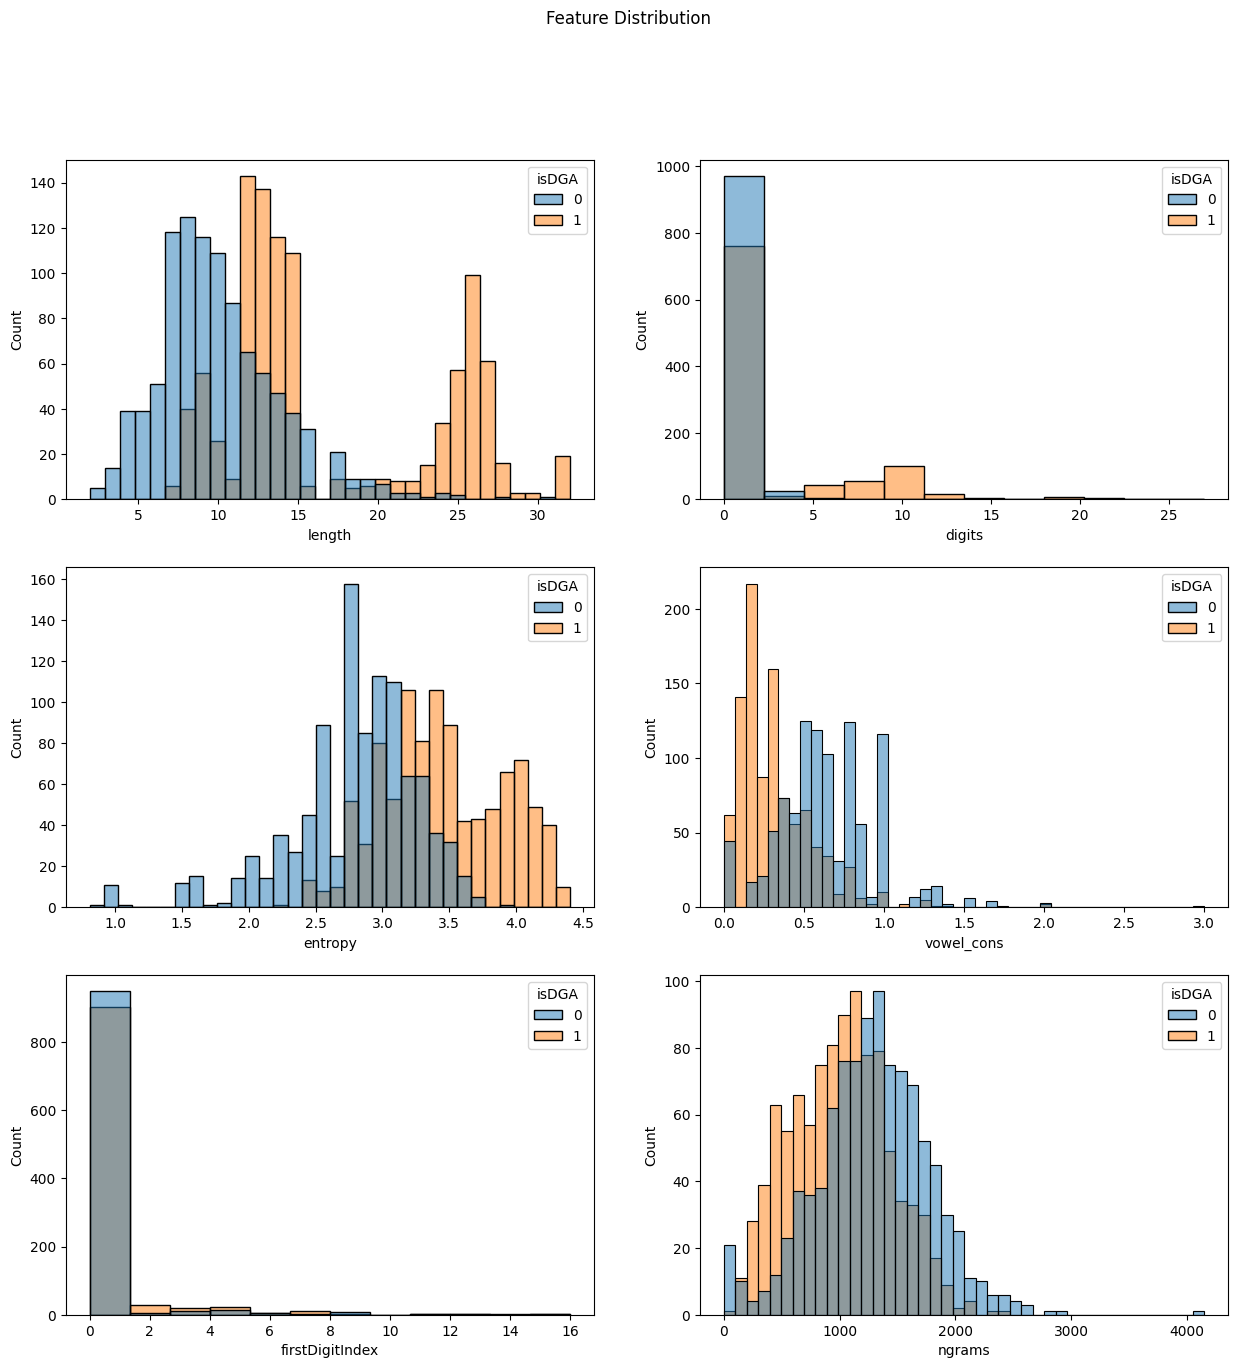

In [41]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Feature Distribution')

sns.histplot(data=df_final, x='length', hue='isDGA', ax=axes[0, 0])
sns.histplot(data=df_final, x='digits', hue='isDGA', ax=axes[0, 1])
sns.histplot(data=df_final, x='entropy', hue='isDGA', ax=axes[1, 0])
sns.histplot(data=df_final, x='vowel_cons', hue='isDGA', ax=axes[1, 1])
sns.histplot(data=df_final, x='firstDigitIndex', hue='isDGA', ax=axes[2, 0])
sns.histplot(data=df_final, x='ngrams', hue='isDGA', ax=axes[2, 1])

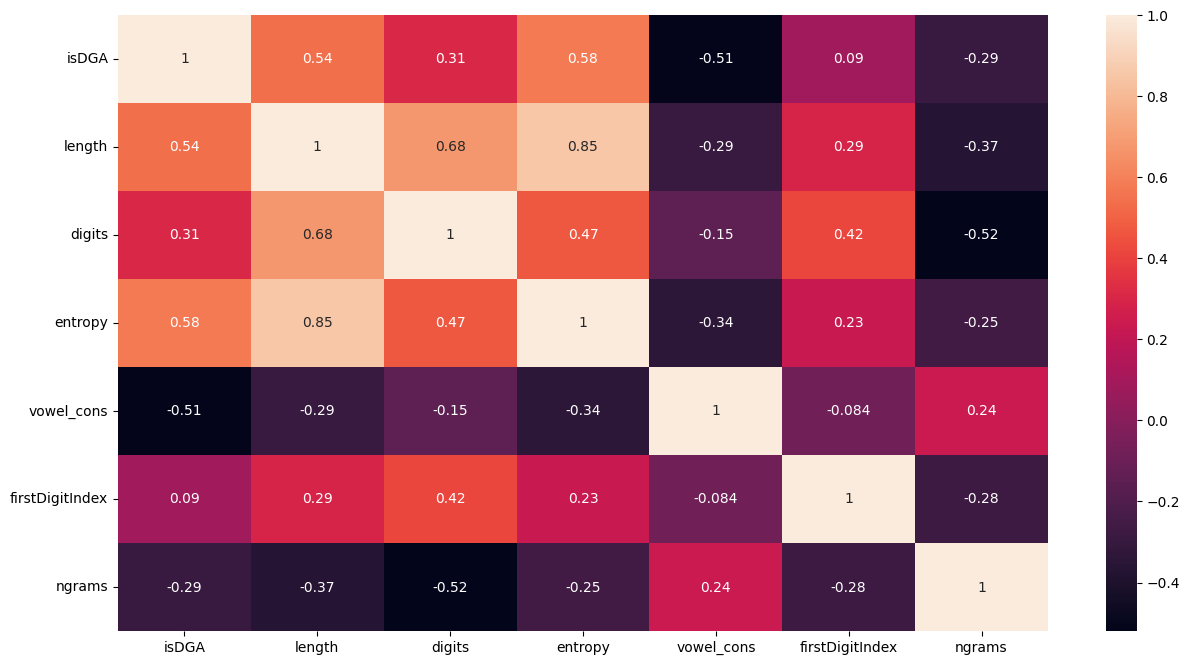

In [42]:
corr = df_final.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True)   
plt.show()

<b><h3>Part 4 - Training the Decision Tree Classifier model</h3></b>

In [43]:
X = df_final[['ngrams', 'entropy', 'length']]
y = df_final['isDGA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [44]:
y_pred = dt_clf.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.50%


In [48]:
# Save the model
# dump(dt_clf, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr2_clf_42.pkl', 'wb'))

In [46]:
hyperparameters = {'criterion': ['gini', 'entropy', 'log_loss'], 
                     'max_depth': [None, 5, 15, 20, 25], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5]} 

dt_clf_grid = GridSearchCV(dt_clf, hyperparameters, scoring='accuracy', cv=10) 
dt_clf_grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='accuracy')

In [50]:
dt_clf_grid.fit(X_train, y_train)
print(f"Best hyperparameters: {dt_clf_grid.best_params_}") 

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [47]:
dt_clf_optimized = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=42)
dt_clf_optimized.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [48]:
y_pred_opt = dt_clf_optimized.predict(X_test)
accuracy_opt = accuracy_score(y_test, y_pred_opt)
print(f"Accuracy: %.2f%%" % (accuracy_opt * 100.0))

Accuracy: 82.75%


In [49]:
# Save the model
dump(dt_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr2_clf_42_gini_maxdp-5_minsmpl-4_minsmpp-20.pkl', 'wb'))

<b><h3>Part 4 - Experiment 2 - Training other classifiers</h3></b>
<h4 style="color: red">Random Forest Classifier</h4>

In [50]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [51]:
y_pred_rf = rf_clf.predict(X_test)

In [52]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: %.2f%%" % (accuracy_rf * 100.0))

Accuracy: 81.50%


In [53]:
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                     'criterion': ['gini', 'entropy', 'log_loss'], 
                     'max_depth': [None, 5, 15, 20, 25], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5]} 

rf_clf_grid = GridSearchCV(rf_clf, hyperparameters, cv=10) 
rf_clf_grid

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150, 200]})

In [60]:
#grid_rf.fit(X_train, y_train)
# print(f"Best hyperparameters: {grid_rf.best_params_}")
## Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 50}

In [54]:
rf_clf_optimized = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, min_samples_leaf=5, min_samples_split=20, random_state=42)
rf_clf_optimized.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=20, random_state=42)

In [55]:
y_pred_rf_opt = rf_clf_optimized.predict(X_test)
accuracy_rf_opt = accuracy_score(y_test, y_pred_rf_opt)
print(f"Accuracy: %.2f%%" % (accuracy_rf_opt * 100.0))

Accuracy: 84.75%


In [56]:
dump(rf_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr2_rf_clf_42_nest-100_maxdp-10_minsmpl-5_minsmpp-20.pkl', 'wb')) 

<h4 style="color: red">K-NN Classifier</h4>

In [57]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [58]:
y_pred_knn = knn_clf.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: %.2f%%" % (accuracy_knn * 100.0))

Accuracy: 71.25%


In [59]:
hyperparameters = {'n_neighbors': [3, 5, 7, 9, 11], 
                   'weights': ['uniform', 'distance'], 
                   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                   'leaf_size': [10, 20, 30, 40, 50], 
                   'p': [1, 2]} 

knn_clf_rand_search = RandomizedSearchCV(knn_clf, hyperparameters, cv=10, n_iter=10, random_state=42)
knn_clf_rand_search

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [ ]:
# clf_knn_random_search.fit(X_train, y_train)
# print(f"Best hyperparameters: {clf_knn_random_search.best_params_}")
## Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'leaf_size': 10, 'algorithm': 'kd_tree'}

In [60]:
knn_clf_optimized = KNeighborsClassifier(n_neighbors=7, weights='distance', leaf_size=10, p=1, algorithm='kd_tree') 
knn_clf_optimized.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=7, p=1,
                     weights='distance')

In [63]:
y_pred_knn_opt = knn_clf_optimized.predict(X_test)
accuracy_knn_opt = accuracy_score(y_test, y_pred_knn_opt)
print(f"Accuracy: %.2f%%" % (accuracy_knn_opt * 100.0))

Accuracy: 72.75%


In [64]:
dump(knn_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr2_knn_clf_42_nneigh-7_weights-dist_leafsize-10_p-1_algo-kd_tree.pkl', 'wb'))

<h4 style="color: red">Boosting Algorithms</h4>

In [65]:
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [66]:
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

Accuracy: 79.00%


In [67]:
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                   'max_depth': [3, 5, 7, 9, 11], 
                   'learning_rate': [0.01, 0.1, 0.2, 0.3], 
                   'subsample': [0.5, 0.7, 0.9], 
                   'colsample_bytree': [0.5, 0.7, 0.9], 
                   'gamma': [0, 1, 5]}

xgb_clf_rand_search = RandomizedSearchCV(xgb_clf, hyperparameters, cv=10, n_iter=10, random_state=42)
xgb_clf_rand_search

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.5, 0.7, 0.9]},
                   random_state=42)

In [ ]:
# clf_xgb_random_search.fit(X_train, y_train) 
# print(f"Best hyperparameters: {clf_xgb_random_search.best_params_}") 
## Best hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.7}

In [68]:
xgb_clf_optimized = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.7, colsample_bytree=0.7, gamma=50, random_state=42)
xgb_clf_optimized.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=50, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [69]:
y_pred_xgb_opt = xgb_clf_optimized.predict(X_test)
accuracy_xgb_opt = accuracy_score(y_test, y_pred_xgb_opt)
print(f"Accuracy: %.2f%%" % (accuracy_xgb_opt * 100.0))

Accuracy: 80.75%


In [70]:
dump(xgb_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr2_xgb_clf_42_nest-200_maxdp-7_lr-0.1_subsample-0.7_colsample-0.7_gamma-50.pkl', 'wb'))

<h3>Second experiment results</h3>

<table class="demo">
<thead>
    <tr>
        <th>Model</th>
        <th>Accuracy</th>
        <th>Accuracy (optimized)</th>
    </tr>
</thead>
    <tbody>
    <tr>
        <td>DecisionTreeClassifier</td>
        <td>77.50%</td>
        <td>82.75%</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>81.50%</td>
        <td>84.75%</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>71.25%</td>
        <td>72.75%</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>79.00%</td>
        <td>80.75%</td>
    </tr>
    </tbody>
</table>

<a id="WorkingOn" href="#intro">Go up</a>

### References
<ul>
    <li>Google Ngram Viewer, <a href="https://books.google.com/ngrams/info" target="_blank">link</a></li>
    <li>n-gram frequency analysis, <a href="https://en.wikipedia.org/wiki/Frequency_analysis">link</a></li>
    <li>Github repository of list of the 10,000 most common English words in order of frequency, <a href="https://github.com/first20hours/google-10000-english">link</a></li>
</ul>